# Loading and Preprocessing Data with TensorFlow:

* When training TensorFlow models on large datasets, use TensorFlow’s own data loading and preprocessing API, called `tf.data`:
    * It is capable of loading and preprocessing data extremely efficiently, reading from multiple files in parallel using multithreading and queuing, shuffling and batching samples.
    * It can do all of this on the fly: It loads and preprocesses the next batch of data across multiple CPU cores, while your GPUs or TPUs are busy training the current batch of data.
    * The `tf.data` API lets you handle datasets that do not fit in memory, and it allows you to make full use of your hardware resources, thereby speeding up training.
    * The `tf.data` API can read text files such as CSVs, binary files w/ fixed-size records, and binary files that use TensorFlow's TFRecord format, w/c supports records of varying sizes.
    * The `tf.data` API has support for reading from SQL databases.
    * The `tf.data` API is a streaming API: you can very efficiently iterate through the dataset's items, but the API is not designed for indexing or slicing.
    
    <br><br>
    * `TFRecord` is a flexible and efficient binary format usually containing protocol buffers (an open source binary format).

* Keras comes w/ preprocessing layers that can be embedded in models:
    * When deploying a model to production, it will be able to ingest raw data directly, w/o having to add any additional preprocessing code. This eliminates the risk of mismatch between the preprocessing code used during training and the preprocessing code used in production, which would likely cause training/serving skew.
    * If you deploy your model in multipleapps coded in different programming languages, you won’t have to reimplement thesame preprocessing code multiple times, which also reduces the risk of mismatch.

# A. `tf.data` API:

* `tf.data.Dataset`:
    * Represents a sequence of data items.
    * When slicing a tuple, a dictionary, or a nested structure, the dataset will only slice the tensors it contains, while preserving the tuple/dictionary structure.

In [1]:
import tensorflow as tf

In [2]:
X = tf.range(10)
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

In [3]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


In [4]:
X_nested = {"a": ([1, 2, 3], [4, 5, 6]), "b": [7, 8, 9]}
dataset = tf.data.Dataset.from_tensor_slices(X_nested)
for item in dataset:
    print(item)

{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=1>, <tf.Tensor: shape=(), dtype=int32, numpy=4>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=7>}
{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=2>, <tf.Tensor: shape=(), dtype=int32, numpy=5>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=8>}
{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=3>, <tf.Tensor: shape=(), dtype=int32, numpy=6>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=9>}


### A.1. Chaining Transformers:

* Once you have a dataset, you can apply all sorts of transformations to it by calling its transformation methods. 
    * Each method returns a new dataset, so you can chain transformations. The dataset methods do not modify datasets - they create new ones.

In [5]:
dataset = tf.data.Dataset.from_tensor_slices(tf.range(10))
dataset = dataset.repeat(3).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


In [6]:
dataset = dataset.map(lambda x: x * 2)  # x is a batch
for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int32)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)
tf.Tensor([16 18], shape=(2,), dtype=int32)


In [7]:
dataset = dataset.filter(lambda x: tf.reduce_sum(x) > 50)
for item in dataset:
    print(item)

tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)


In [8]:
# take a look at 2 items from a dataset
for item in dataset.take(2):
    print(item)

tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)


### A.2. Shuffling the Data:

* Gradient descent works best when the instances in the training set are independent and identically distributed (IID). A simple way to ensure this is to shuffle the instances, using the `shuffle()` method.

* `shuffle()` method:
    * Create a new dataset that will start by filling up a buffer w/ the first items of the source dataset.
    * Then, whenever it is asked for an item, it will pull one out randomly from the buffer and replace it with a fresh one from the source dataset, until it has iterated entirely through the source dataset.
    * At this point it will continue to pull out items randomly from the buffer until it is empty.
    * You must specify the buffer size, and it is important to make it large enough, or else shuffling will not be very effective.Just don’t exceed the amount of RAM you have, though even if you have plenty of it, there’s no need to go beyond the dataset’s size.

* For a large dataset that does not fit in memory, this simple shuffling-buffer approach may not be sufficient, since the buffer will be small compared to the dataset. One solution is to shuffle the source data itself.
    * Even if the source data is shuffled, you will usually want to shuffle it some more, or else the same order will be repeated at each epoch, and the model may end up being biased (e.g., due to some spurious patterns present by chance in the source data’s order).
    * To shuffle the instances some more, a common approach is to split the source data into multiple files, then read them in a random order during training.
    * However, instances located in the same file will still end up close to each other. To avoid this you can pick multiple files randomly and read them simultaneously, interleaving their records.
    * Then on top of that you can add a shuffling buffer using the `shuffle()` method.

In [9]:
dataset = tf.data.Dataset.range(10).repeat(2)
dataset = dataset.shuffle(buffer_size=4, seed=42).batch(7)
for item in dataset:
    print(item)

tf.Tensor([1 4 2 3 5 0 6], shape=(7,), dtype=int64)
tf.Tensor([9 8 2 0 3 1 4], shape=(7,), dtype=int64)
tf.Tensor([5 7 9 6 7 8], shape=(6,), dtype=int64)


### A.3. Interleaving lines from multiple files:

* `tf.data.Dataset.list_files(train_filepaths)`:
    * `lift_file()` function returns a dataset that shuffles the filepaths. (can be turned off, `shuffle=False`)

* `interleave()`:
    * This method when applied to an instance of `list_files()` will read from `cycle_length` no. of files at a a time and interleave their lines:
        * This will create a dataset that will pull  `cycle_length` no of filepaths from the instance of the `list_files`
        * And for each one, it will call the function you gave it to create a new dataset.
        * For interleaving to work best, it is preferable to have files of identical length; otherwise the end of the longest file will not be interleaved.
    * By default, does not use parallelism; it just reads one line at a  time from each file, sequentially.
        * To read the files in parallel, set the argment `num_parallel_calls` to the number of threads you want or set it to `tf.data.AUTOTUNE` to make tensor flow choose the right number of threads dynamically based on the available CPU.

* For a very large dataset that does not fit in memory, you will typically want to split it into many files first, then have TensorFlow read these files in parallel. 

In [10]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

In [11]:
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

In [12]:
import numpy as np
from pathlib import Path

In [13]:
# Split the dataset and save it to 20 csv files:
def save_to_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = Path() / "datasets" / "housing"
    housing_dir.mkdir(parents=True, exist_ok=True)
    filename_format = "my_{}_{:02d}.csv"

    filepaths = []
    m = len(data)
    chunks = np.array_split(np.arange(m), n_parts)
    for file_idx, row_indices in enumerate(chunks):
        part_csv = housing_dir / filename_format.format(name_prefix, file_idx)
        filepaths.append(str(part_csv))
        with open(part_csv, "w") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_csv_files(test_data, "test", header, n_parts=10)

In [14]:
print("".join(open(train_filepaths[0]).readlines()[:4]))

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442
5.3275,5.0,6.490059642147117,0.9910536779324056,3464.0,3.4433399602385686,33.69,-117.39,1.687
3.1,29.0,7.5423728813559325,1.5915254237288134,1328.0,2.2508474576271187,38.44,-122.98,1.621



In [15]:
train_filepaths

['datasets\\housing\\my_train_00.csv',
 'datasets\\housing\\my_train_01.csv',
 'datasets\\housing\\my_train_02.csv',
 'datasets\\housing\\my_train_03.csv',
 'datasets\\housing\\my_train_04.csv',
 'datasets\\housing\\my_train_05.csv',
 'datasets\\housing\\my_train_06.csv',
 'datasets\\housing\\my_train_07.csv',
 'datasets\\housing\\my_train_08.csv',
 'datasets\\housing\\my_train_09.csv',
 'datasets\\housing\\my_train_10.csv',
 'datasets\\housing\\my_train_11.csv',
 'datasets\\housing\\my_train_12.csv',
 'datasets\\housing\\my_train_13.csv',
 'datasets\\housing\\my_train_14.csv',
 'datasets\\housing\\my_train_15.csv',
 'datasets\\housing\\my_train_16.csv',
 'datasets\\housing\\my_train_17.csv',
 'datasets\\housing\\my_train_18.csv',
 'datasets\\housing\\my_train_19.csv']

In [17]:
# Build an input pipeline:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)

# The filepaths are now shuffled
for filepath in filepath_dataset:
    print(filepath)

tf.Tensor(b'datasets\\housing\\my_train_05.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_16.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_01.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_17.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_00.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_14.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_10.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_02.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_12.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_19.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_07.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_09.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_13.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_15.csv', sh

In [18]:
n_readers = 5
dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
    cycle_length=n_readers)

In [19]:
for line in dataset.take(5):
    print(line)

tf.Tensor(b'4.5909,16.0,5.475877192982456,1.0964912280701755,1357.0,2.9758771929824563,33.63,-117.71,2.418', shape=(), dtype=string)
tf.Tensor(b'2.4792,24.0,3.4547038327526134,1.1341463414634145,2251.0,3.921602787456446,34.18,-118.38,2.0', shape=(), dtype=string)
tf.Tensor(b'4.2708,45.0,5.121387283236994,0.953757225433526,492.0,2.8439306358381504,37.48,-122.19,2.67', shape=(), dtype=string)
tf.Tensor(b'2.1856,41.0,3.7189873417721517,1.0658227848101265,803.0,2.0329113924050635,32.76,-117.12,1.205', shape=(), dtype=string)
tf.Tensor(b'4.1812,52.0,5.701388888888889,0.9965277777777778,692.0,2.4027777777777777,33.73,-118.31,3.215', shape=(), dtype=string)


### A.4. Preprocessing the Data:


In [22]:
X_train.shape

(11610, 8)

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [21]:
X_mean, X_std = scaler.mean_, scaler.scale_  
n_inputs = 8

def parse_csv_line(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    return tf.stack(fields[:-1]), tf.stack(fields[-1:])

def preprocess(line):
    x, y = parse_csv_line(line)
    return (x - X_mean) / X_std, y

In [23]:
preprocess(b'4.2083,44.0,5.3232,0.9171,846.0,2.3370,37.47,-122.2,2.782')

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([ 0.16579159,  1.216324  , -0.05204564, -0.39215982, -0.5277444 ,
        -0.2633488 ,  0.8543046 , -1.3072058 ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.782], dtype=float32)>)

### A.5. Putting Everything Together:

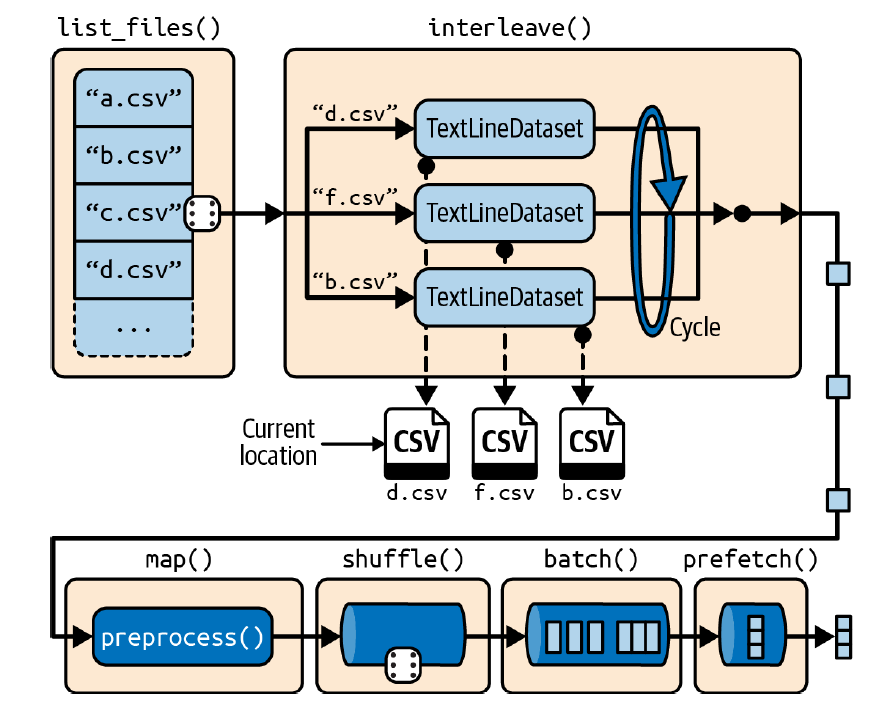

In [24]:
def csv_reader_dataset(filepaths, n_readers=5, n_read_threads=None,
                       n_parse_threads=5, shuffle_buffer_size=10_000, seed=42,
                       batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths, seed=seed)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.shuffle(shuffle_buffer_size, seed=seed)
    return dataset.batch(batch_size).prefetch(1)

In [25]:
# sample
example_set = csv_reader_dataset(train_filepaths, batch_size=3)
for X_batch, y_batch in example_set.take(2):
    print("X =", X_batch)
    print("y =", y_batch)
    print()

X = tf.Tensor(
[[-1.3957452  -0.04940685 -0.22830808  0.22648273  2.2593622   0.35200632
   0.9667386  -1.4121602 ]
 [ 2.7112627  -1.0778131   0.69413143 -0.14870553  0.51810503  0.3507294
  -0.82285154  0.80680597]
 [-0.13484643 -1.868895    0.01032507 -0.13787179 -0.12893449  0.03143518
   0.2687057   0.13212144]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[1.819]
 [3.674]
 [0.954]], shape=(3, 1), dtype=float32)

X = tf.Tensor(
[[ 0.09031774  0.9789995   0.1327582  -0.13753782 -0.23388447  0.10211545
   0.97610843 -1.4121602 ]
 [ 0.05218809 -2.0271113   0.2940109  -0.02403445  0.16218767 -0.02844518
   1.4117942  -0.93737936]
 [-0.672276    0.02970133 -0.76922584 -0.15086786  0.4962024  -0.02741998
  -0.7853724   0.77182245]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[2.725]
 [1.205]
 [1.625]], shape=(3, 1), dtype=float32)



In [26]:
# Methods of tf.data.Dataset Class
for m in dir(tf.data.Dataset):
    if not (m.startswith("_") or m.endswith("_")):
        func = getattr(tf.data.Dataset, m)
        if hasattr(func, "__doc__"):
            print("● {:21s}{}".format(m + "()", func.__doc__.split("\n")[0]))

● apply()              Applies a transformation function to this dataset.
● as_numpy_iterator()  Returns an iterator which converts all elements of the dataset to numpy.
● batch()              Combines consecutive elements of this dataset into batches.
● bucket_by_sequence_length()A transformation that buckets elements in a `Dataset` by length.
● cache()              Caches the elements in this dataset.
● cardinality()        Returns the cardinality of the dataset, if known.
● choose_from_datasets()Creates a dataset that deterministically chooses elements from `datasets`.
● concatenate()        Creates a `Dataset` by concatenating the given dataset with this dataset.
● element_spec()       The type specification of an element of this dataset.
● enumerate()          Enumerates the elements of this dataset.
● filter()             Filters this dataset according to `predicate`.
● flat_map()           Maps `map_func` across this dataset and flattens the result.
● from_generator()     Create

### A.6. Prefetching:



In [27]:
train_set = csv_reader_dataset(train_filepaths)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

In [28]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [29]:
# Using the dataset with keras
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", 
                          kernel_initializer="he_normal",
                          input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(1),
])
model.compile(loss="mse", optimizer="sgd")
model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
363/363 [==============================] - 7s 13ms/step - loss: 5.3322 - val_loss: 3.6873
Epoch 2/5
363/363 [==============================] - 2s 6ms/step - loss: 0.8162 - val_loss: 87.2517
Epoch 3/5
363/363 [==============================] - 2s 5ms/step - loss: 0.5436 - val_loss: 230.7708
Epoch 4/5
363/363 [==============================] - 2s 5ms/step - loss: 1.6739 - val_loss: 0.6706
Epoch 5/5
363/363 [==============================] - 2s 5ms/step - loss: 0.3998 - val_loss: 0.7057


In [30]:
test_mse = model.evaluate(test_set)
new_set = test_set.take(3)  # pretend we have 3 new samples
y_pred = model.predict(new_set)  # or you could just pass a NumPy array

3/3 [==============================] - 1s 31ms/step
